# Exploratory Data Analysis for Pythia Generated Jet Images for Location Aware Generative Adversarial Network Training

### Download Data

**Reference Paper** for this project is [here](https://arxiv.org/pdf/1701.05927.pdf).
<br>
**Data** is available [here](https://zenodo.org/record/269622#.Xkq0-jIzapq).

In [0]:
import os.path
import requests
from tqdm import tqdm_notebook as tqdm

In [0]:
def download(url):
    fname = url.split("/")[-1]
    if not os.path.exists(fname):
        # Streaming, so we can iterate over the response.
        r = requests.get(url, stream=True)
        total_size = int(r.headers.get('content-length', 0))
        block_size = 1024

        t=tqdm(total=total_size, unit='iB', unit_scale=True)
        with open(fname, 'wb') as f:
            for data in r.iter_content(block_size):
                t.update(len(data))
                f.write(data)
        t.close()

        if total_size != 0 and t.n != total_size:
            print("ERROR, something went wrong")
    else:
        print("Data Already Downloaded")

In [0]:
url = "https://zenodo.org/record/269622/files/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5"

In [21]:
download(url)

### Load Data and Libraries


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import h5py

In [0]:
filename = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'

images = 0
df = {}

with h5py.File(name=filename, mode="r") as f:
    for key in f.keys():
      if key != "image":
          df[key] = np.array(f[key])
      else:
          images = np.array(f[key])
f.close()
del f

Attribute of the dataset are as follow:
* **image** : array of dim (872666, 25, 25), contains the pixel intensities of each 25x25 image
* **signal** : binary array to identify signal (1, i.e. W boson) vs background (0, i.e. QCD)
* **jet_eta**: eta coordinate per jet
* **jet_phi**: phi coordinate per jet
* **jet_mass**: mass per jet
* **jet_pt**: transverse momentum per jet
* **jet_delta_R**: distance between leading and subleading subjets if 2 subjets present, else 0
* **tau_1, tau_2, tau_3**: substructure variables per jet (a.k.a. n-subjettiness, where n=1, 2, 3)
* **tau_21**: tau2/tau1 per jet
* **tau_32**: tau3/tau2 per jet

Information is taken from [here](https://zenodo.org/record/269622#.Xkq0-jIzapq).

### Data Statistics

In [24]:
pd.DataFrame(df).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872666 entries, 0 to 872665
Data columns (total 11 columns):
jet_delta_R    872666 non-null float32
jet_eta        872666 non-null float32
jet_mass       872666 non-null float32
jet_phi        872666 non-null float32
jet_pt         872666 non-null float32
signal         872666 non-null float32
tau_1          872666 non-null float32
tau_2          872666 non-null float32
tau_21         872666 non-null float32
tau_3          872666 non-null float32
tau_32         872666 non-null float32
dtypes: float32(11)
memory usage: 36.6 MB


In [25]:
pd.DataFrame(df).describe()

,jet_delta_R,jet_eta,jet_mass,jet_phi,jet_pt,signal,tau_1,tau_2,tau_21,tau_3,tau_32
count,872666.000000,872666.000000,872666.000000,872666.000000,872666.000000,872666.0,872666.000000,872666.000000,872666.000000,872666.000000,872666.000000
mean,0.599200,0.000975,77.920799,3.137256,275.284485,0.5,0.204142,0.073467,0.368177,0.048586,0.660223
std,0.150271,1.048868,9.311319,1.813353,14.492263,0.5,0.054008,0.037783,0.173302,0.026771,0.120327
min,0.000000,-1.999968,60.000027,0.000008,250.000031,0.0,0.048674,0.000725,0.003463,0.000000,0.000000
25%,0.500033,-0.841927,71.264097,1.566417,262.650650,0.0,0.164827,0.043723,0.224894,0.027443,0.588793
50%,0.578704,0.000773,78.214741,3.133180,275.312439,0.5,0.205124,0.067921,0.351941,0.044068,0.677434
75%,0.685856,0.842834,83.600691,4.707176,287.844330,1.0,0.244204,0.098206,0.501502,0.065582,0.748942
max,1.091765,1.999981,99.999870,6.283181,299.999908,1.0,0.394305,0.272232,0.918190,0.200013,0.982122


### Data Histograms

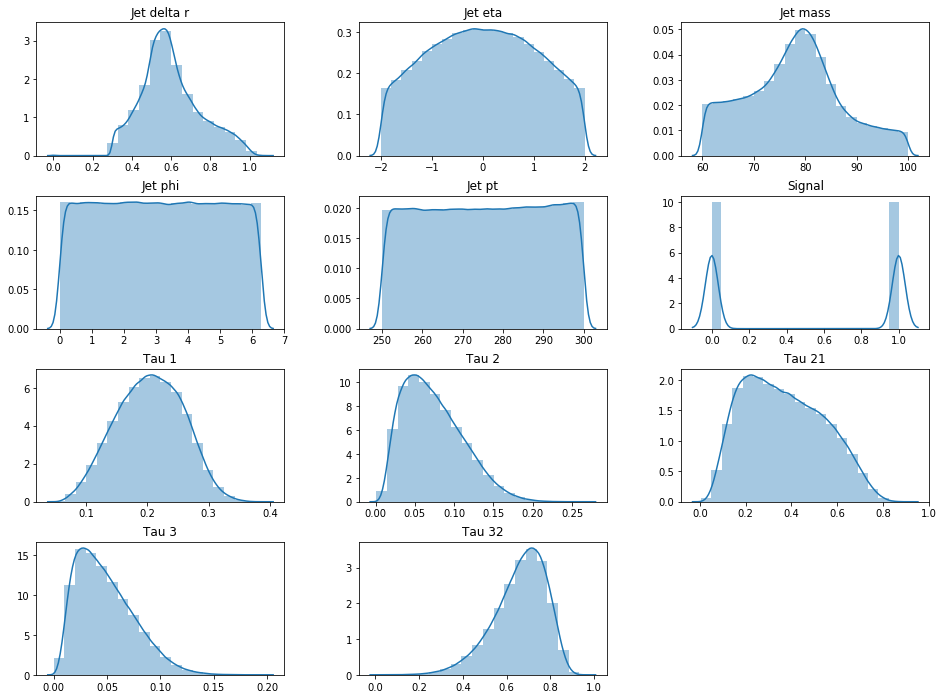

In [26]:
plt.rcParams["figure.figsize"] = 16, 12
plt.subplots_adjust(wspace=0.3, hspace=0.3)

weights = np.ones_like(df["tau_1"])/float(len(df["tau_1"]))

for idx, key in enumerate(df.keys()):
    plt.subplot(4, 3, idx+1)
    sns.distplot(df[key], bins=20)
    plt.title(key.replace("_", " ").capitalize())
plt.show()

**Inference**: Here Signal is the only categeorical variable and we can say that there are two population. The distribution of data for two values of signalsa are almost identical which could be the reason that the distribution of data wrt to tother variable is not multi modal. We have to assess the two populations seprately.

### Conditional Data Histograms
Data is conditioned on signal variable.

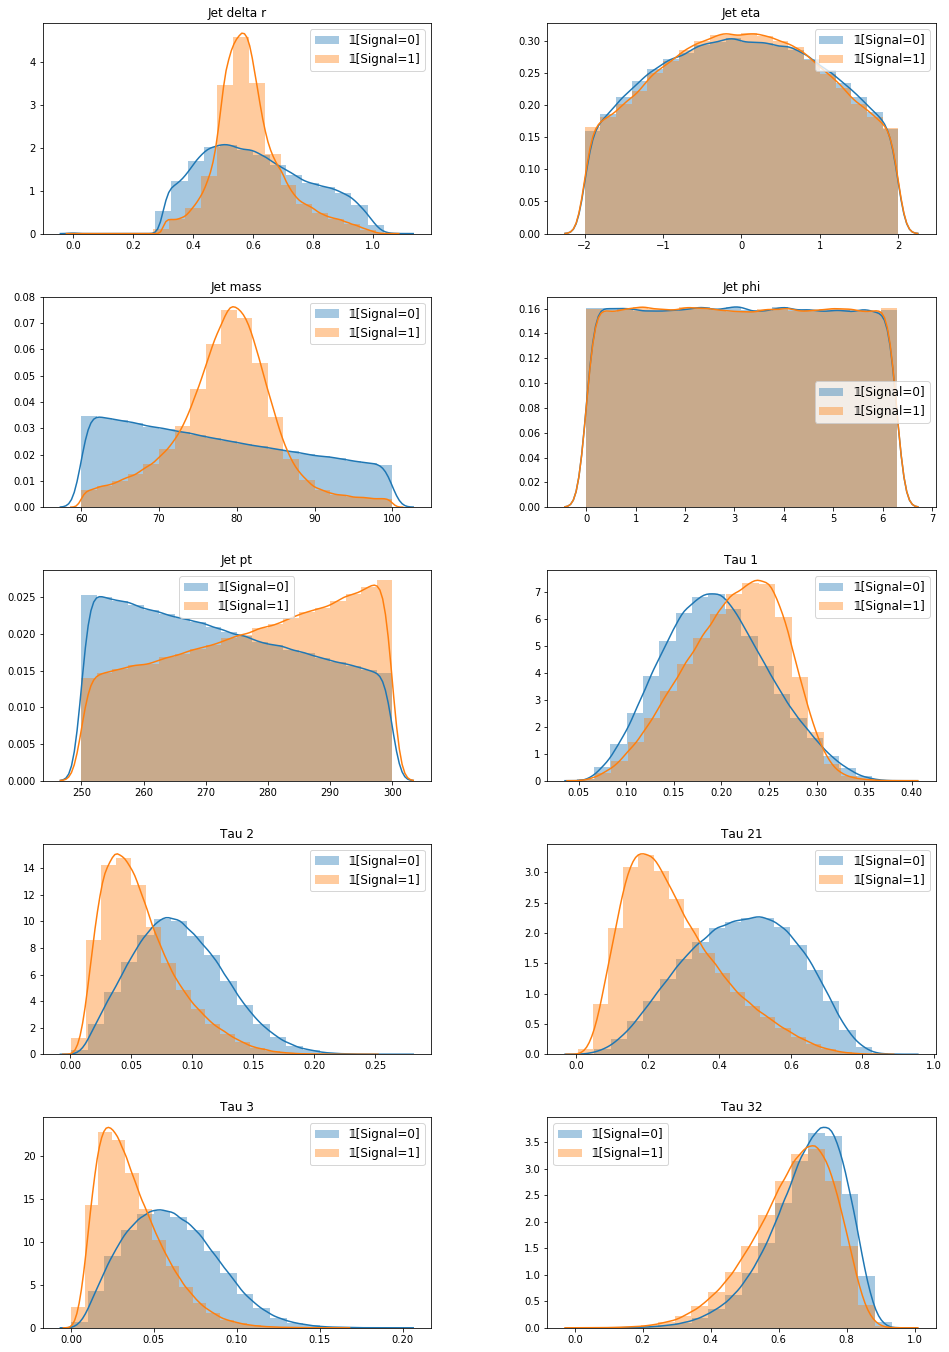

In [27]:
plt.rcParams["figure.figsize"] = 16, 24
plt.subplots_adjust(wspace=0.3, hspace=0.3)

idx = (df["signal"] == 1)

keys = list(df.keys())
keys.remove("signal")

for i, key in enumerate(keys):
    plt.subplot(5, 2, i+1)
    sns.distplot(df[key][~idx], bins=20, label="𝟙[Signal=0]")
    sns.distplot(df[key][idx], bins=20, label="𝟙[Signal=1]")
    plt.title(key.replace("_", " ").capitalize())
    plt.legend(prop={'size': 12})
plt.show()

**Inference**: These histograms validates our assumption that there exists two population in the data which we have already predicated in the previous section.

### Box Plot

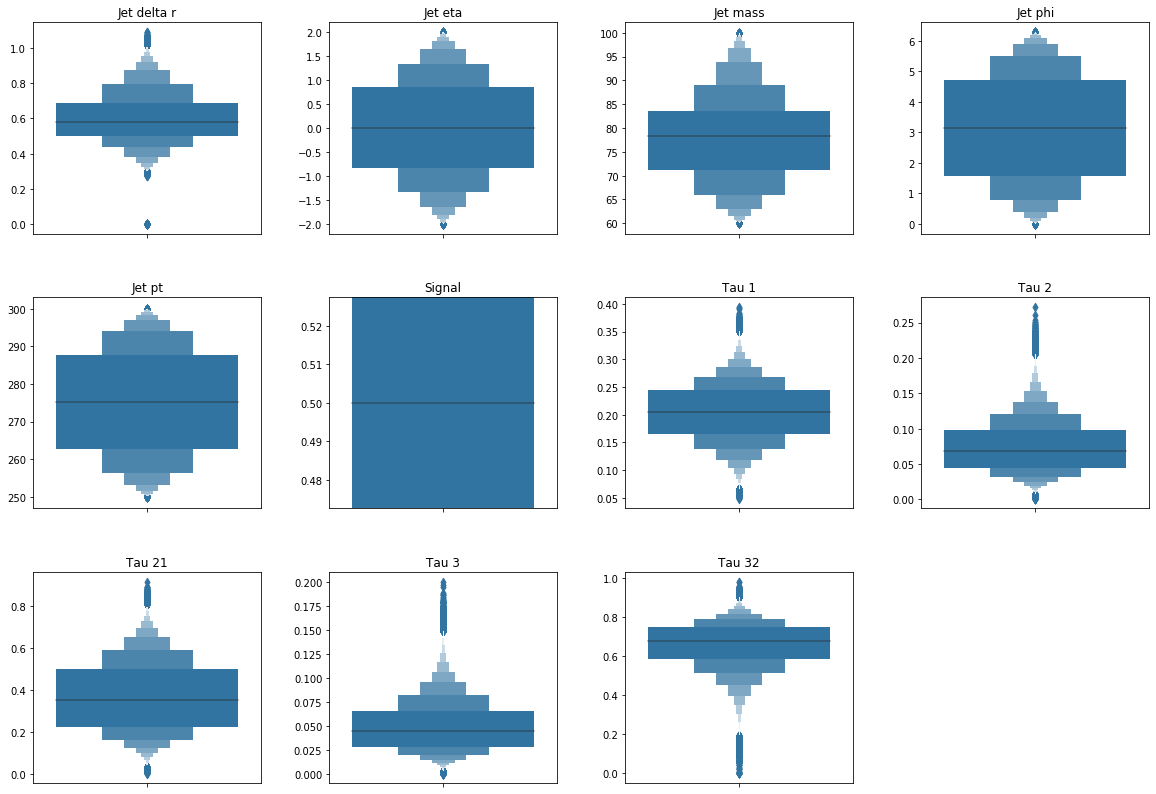

In [28]:
plt.rcParams["figure.figsize"] = 20, 14
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, key in enumerate(df.keys()):
    plt.subplot(3, 4, idx+1)
    sns.boxenplot(y=df[key])
    plt.title(key.replace("_", " ").capitalize())
plt.show()

**Inference**: It's difficualt to analysze the presence of outliers fro the hsitograms as data size is very very large. hence we ahve to go with box plots which tells a lot more about distributions through properties like quntiles and outliers. here important thing to notice is that signiifcant amount of outliers in the attributes with name Tau.

### Conditional Box Plot
Conditioned on Signal Variable

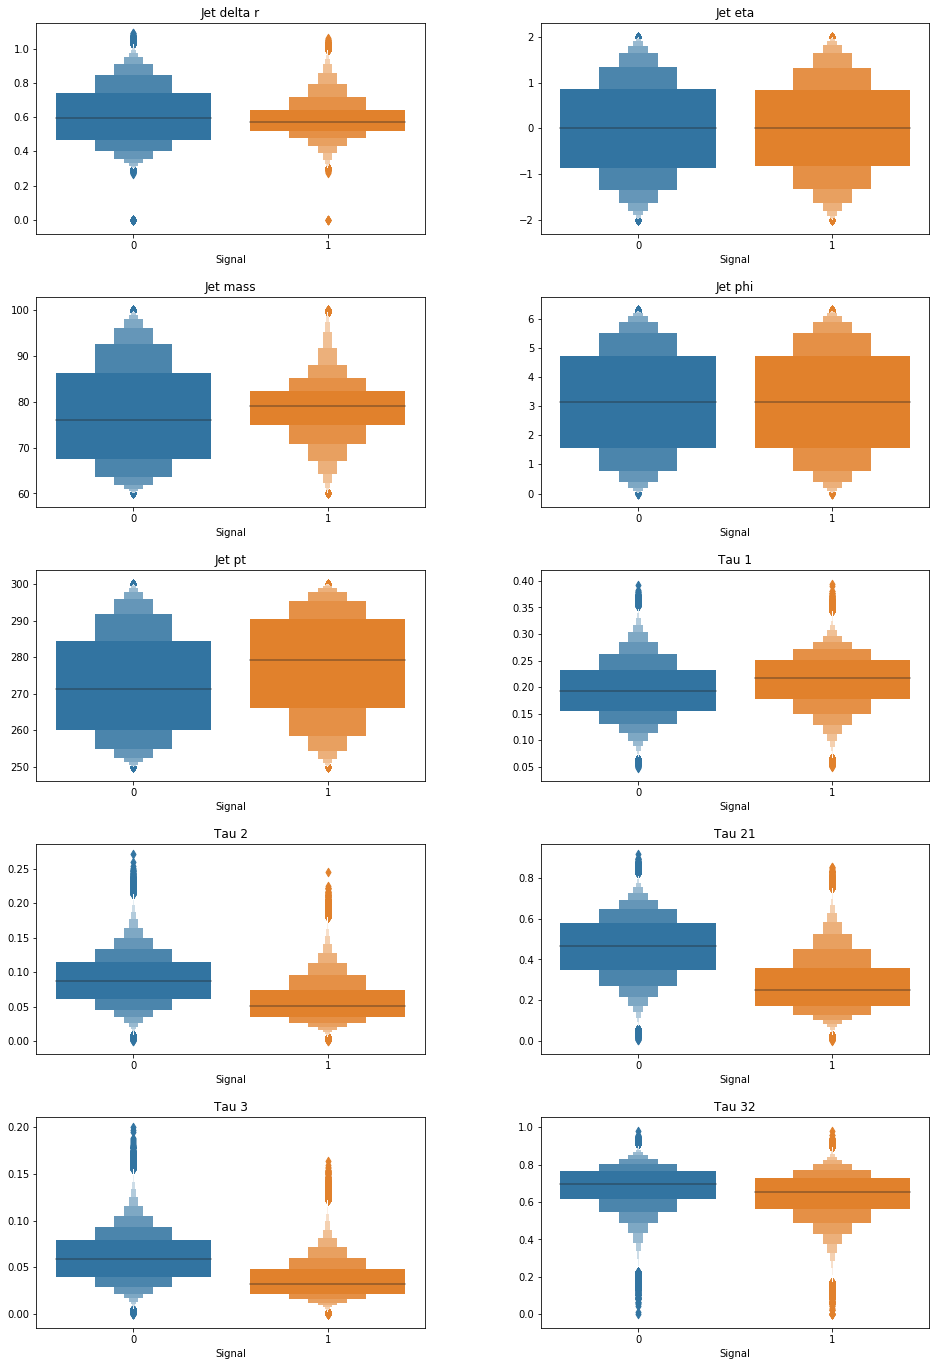

In [29]:
plt.rcParams["figure.figsize"] = 16, 24
plt.subplots_adjust(wspace=0.3, hspace=0.3)

keys = list(df.keys())
keys.remove("signal")

for i, key in enumerate(keys):
    plt.subplot(5, 2, i+1)
    sns.boxenplot(x=df["signal"].astype(np.int8), y=df[key])
    plt.xlabel("Signal")
    plt.title(key.replace("_", " ").capitalize())
plt.show()

**Inference**: Since there are two populations we ahve to estimate outliers for each popualtion. But thoriugh visualizations it seems that outliers distributon in both populatons seems similar after applying bias correction.

### Violin Plot

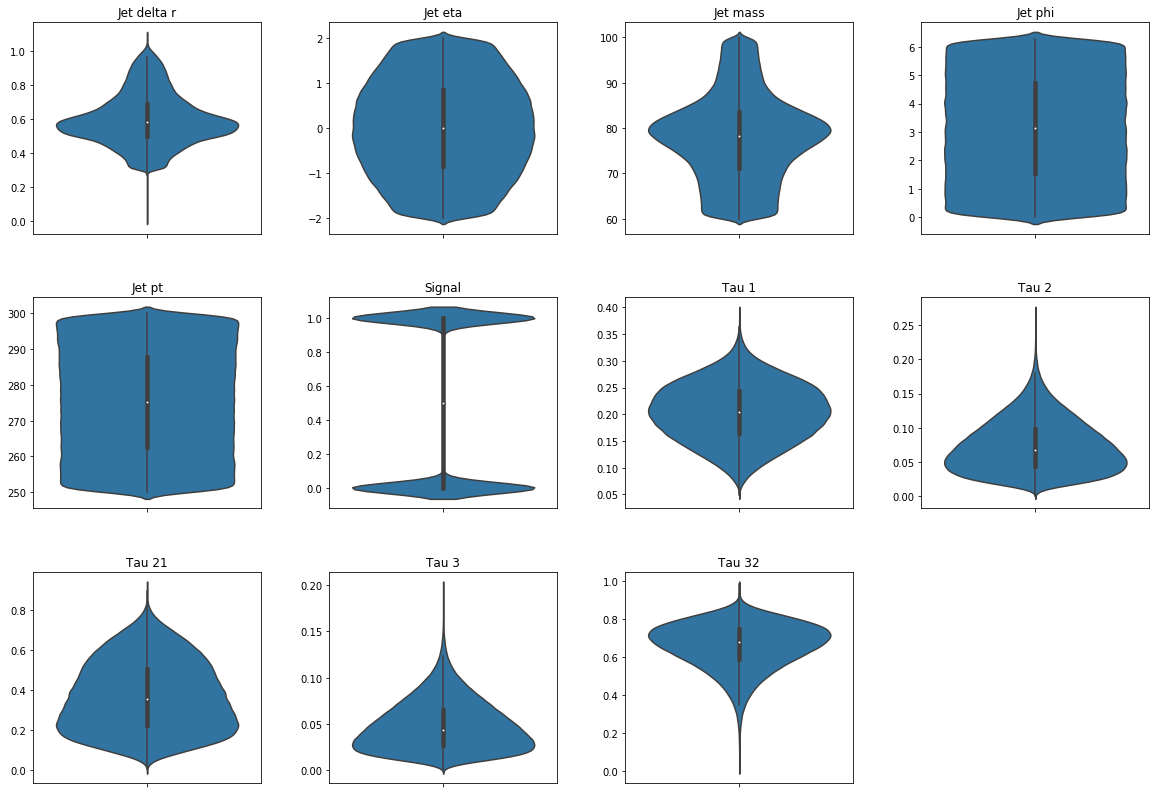

In [30]:
plt.rcParams["figure.figsize"] = 20, 14
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, key in enumerate(df.keys()):
    plt.subplot(3, 4, idx+1)
    sns.violinplot(y=df[key])
    plt.title(key.replace("_", " ").capitalize())
plt.show()

**Inference**: These plots combines the properties of box plot and histogram. It's just another way to visualize the data density. Here it's simply inferences are quite similar to previous two cases.

### Conditional Violin Plot
Conditioned on Signal Variable

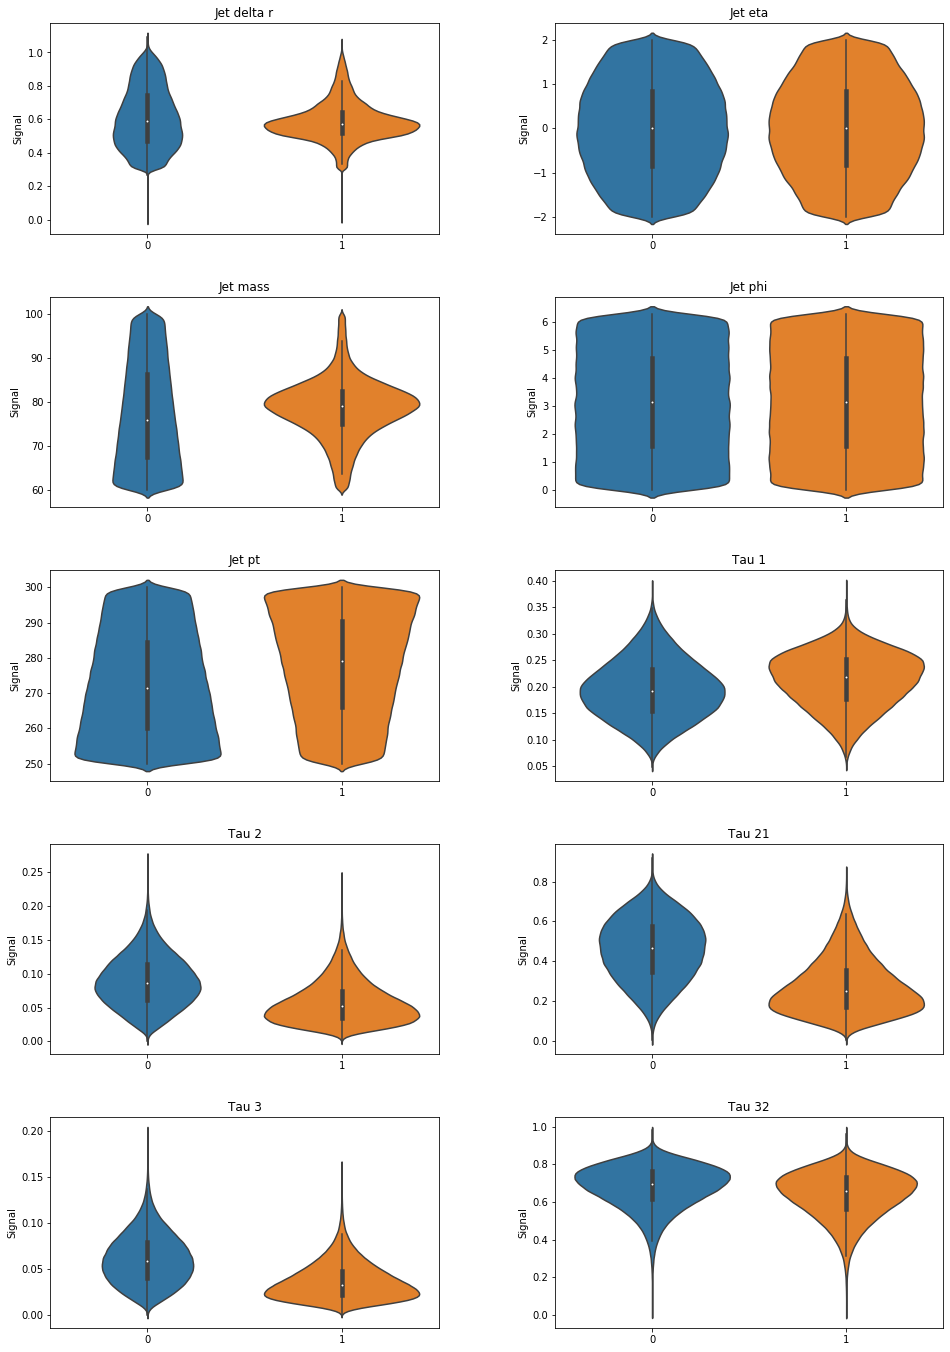

In [31]:
plt.rcParams["figure.figsize"] = 16, 24
plt.subplots_adjust(wspace=0.3, hspace=0.3)

keys = list(df.keys())
keys.remove("signal")

for i, key in enumerate(keys):
    plt.subplot(5, 2, i+1)
    sns.violinplot(x=df["signal"].astype(np.int8), y=df[key])
    plt.ylabel("Signal")
    plt.title(key.replace("_", " ").capitalize())
plt.show()

### Correlation Plot

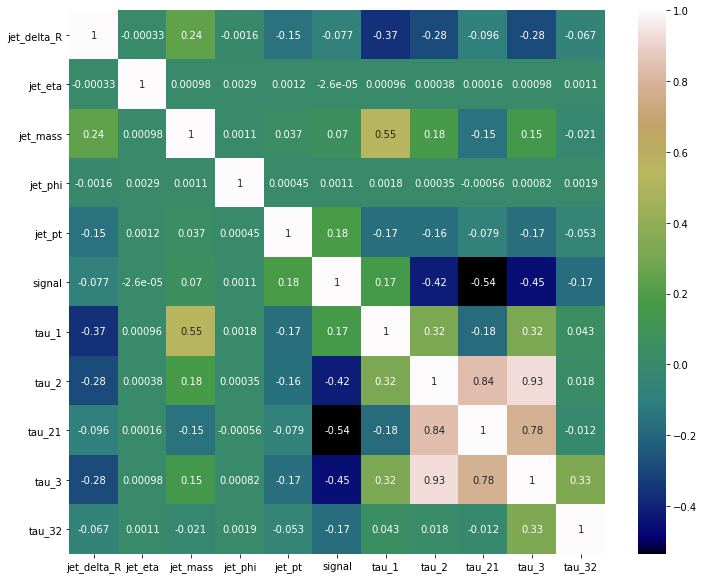

In [66]:
plt.rcParams["figure.figsize"] = 12, 10

sns.heatmap(pd.DataFrame(df).corr(), annot=True, cmap="gist_earth")
plt.show()

### Conditional Correlation Plot
Conditioned on Signal Variable

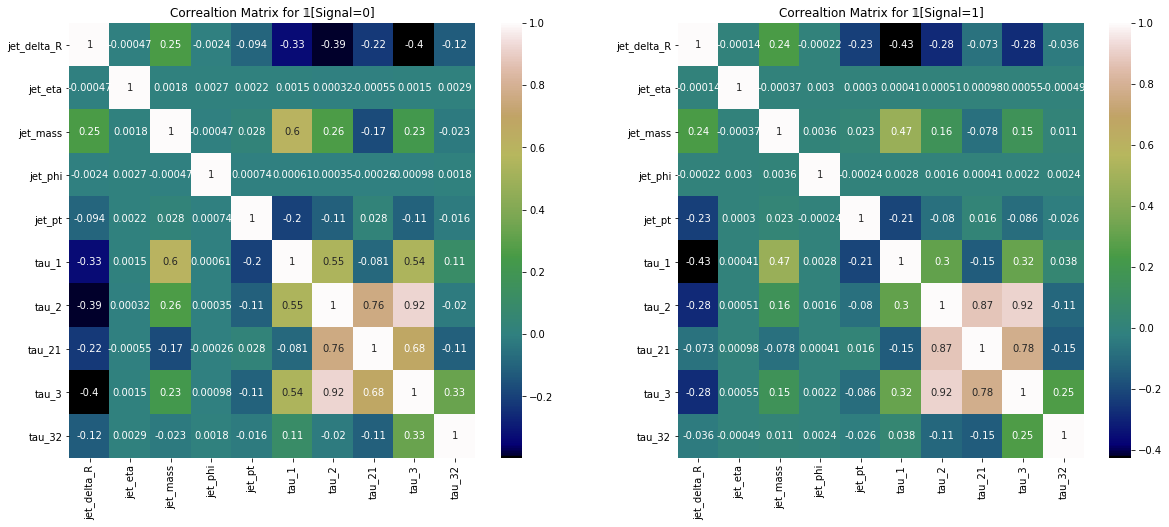

In [70]:
plt.rcParams["figure.figsize"] = 20, 8

idx = (df["signal"] == 1)

plt.subplot(1, 2, 1)
sns.heatmap((pd.DataFrame(df)[~idx][keys]).corr(), annot=True, cmap="gist_earth")
plt.title("Correaltion Matrix for 𝟙[Signal=0]")

plt.subplot(1, 2, 2)
sns.heatmap((pd.DataFrame(df)[idx][keys]).corr(), annot=True, cmap="gist_earth")
plt.title("Correaltion Matrix for 𝟙[Signal=1]")
plt.show()

**Inference**: Correlation trend is quite simlar in both populations as well in the misture of two population with a few exceptions.

### Image Visualization

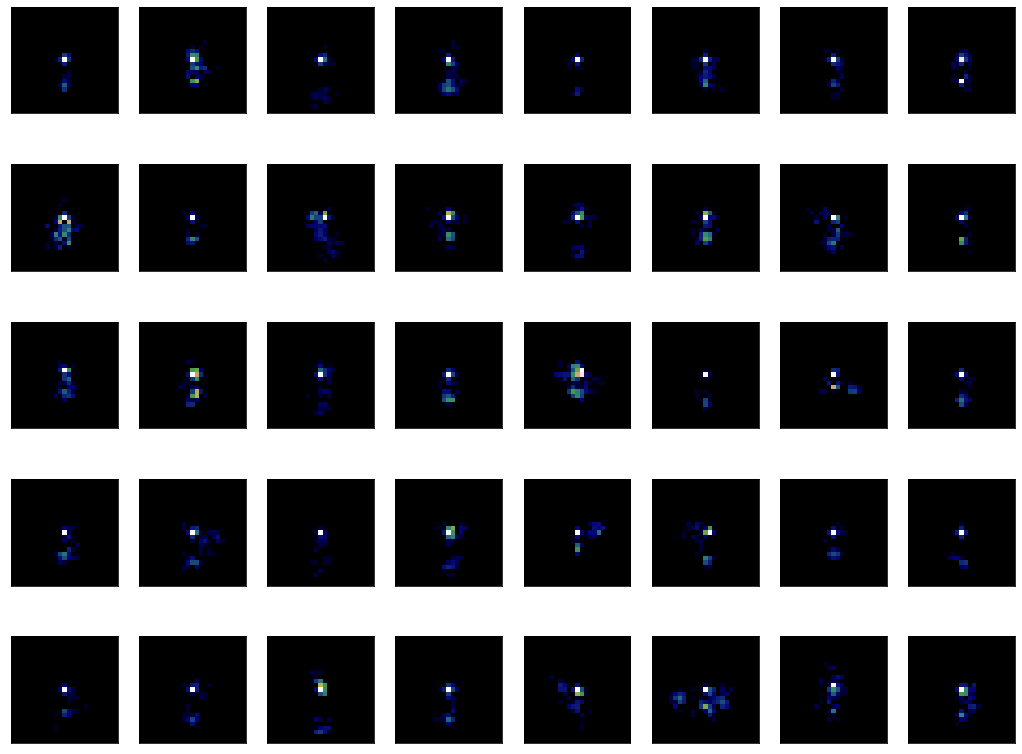

In [89]:
plt.rcParams["figure.figsize"] = 18, 14

for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.imshow(images[np.random.randint(0, images.shape[0])], cmap="gist_earth")
    plt.xticks([])
    plt.yticks([])

plt.show()